# Pneumonia Detection using Transfer Learning (VGG16) 

In this notebook, we will build a well-tuned pneumonia detection model using transfer learning with VGG16. 
We will also apply:
- Proper data augmentation
- Class imbalance handling
- Early stopping & model checkpointing
- Visualization of training progress
- Evaluation with classification report and confusion matrix


In [3]:
# Step 1: Import Required Libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf


## Dataset Preparation

- We will load the chest X-ray dataset (train, val, test)
- Apply preprocessing suitable for VGG16
- Setup data generators with augmentation for training data


In [ ]:
# Dataset directory path 
dataset_dir = r"../data"

train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# Image size for VGG16
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # important for evaluation
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Building — Transfer Learning with VGG16

- Load VGG16 with ImageNet weights
- Freeze initial layers
- Unfreeze last few layers for fine-tuning
- Add custom dense layers


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load VGG16 without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 15 layers (more aggressive freezing for better generalization)
for layer in base_model.layers[:15]:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 7,473,665 (28.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Model Training and Saving

- EarlyStopping to prevent overfitting
- ModelCheckpoint to save best model automatically
- ReduceLROnPlateau to control learning rate
- Save final model after training


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("../models/vgg16/best_vgg16_model.keras", monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

# Training
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# Save final model after training (optional but safe)
model.save("../models/vgg16/final_vgg16_model.keras")


c:\Users\Poojitha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3651s 22s/step - accuracy: 0.7211 - loss: 0.7951 - val_accuracy: 0.9375 - val_loss: 0.2014 - learning_rate: 1.0000e-05
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3522s 22s/step - accuracy: 0.9225 - loss: 0.2118 - val_accuracy: 0.9375 - val_loss: 0.2174 - learning_rate: 1.0000e-05
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3512s 22s/step - accuracy: 0.9415 - loss: 0.1464 - val_accuracy: 0.9375 - val_loss: 0.1948 - learning_rate: 1.0000e-05
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3547s 22s/step - accuracy: 0.9614 - loss: 0.1059 - val_accuracy: 0.9375 - val_loss: 0.0874 - learning_rate: 1.0000e-05
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3630s 22s/step - accuracy: 0.9682 - loss: 0.0941 - val_accuracy: 1.0000 - val_loss: 0.0735 - learning_rate: 1.0000e-05
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3658s 22s/step - accuracy: 0.9710 - loss: 0.0813 - val_accuracy: 1.0000 - val_loss: 0.0686 - learning_rate: 1.0000e-05
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 3525s 

## Step 4 — Redefining Test Dataset for Evaluation

Although we’re in the same notebook, we’re explicitly redefining the dataset and `test_generator` to ensure clean evaluation of the saved model. This avoids dependencies on previously run cells and makes the evaluation reproducible.


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset directory
dataset_dir = r"../data"

# Image size and batch
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Only need test data here
test_dir = os.path.join(dataset_dir, "test")

# VGG16 preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # for correct evaluation
)


Found 624 images belonging to 2 classes.


## Step 5 — Evaluate the Best Saved VGG16 Model

- Load the best model from disk.
- Evaluate on test data.
- Show classification report & confusion matrix.
- Visualize model performance.


c:\Users\Poojitha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 437s 21s/step - accuracy: 0.8608 - loss: 0.4132

✅ Test Accuracy: 90.71%
20/20 ━━━━━━━━━━━━━━━━━━━━ 485s 24s/step

📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



C:\Users\Poojitha\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


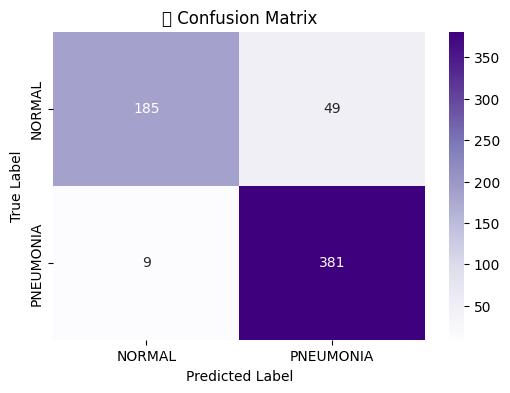

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved model
model = load_model("../models/vgg16/best_vgg16_model.keras")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict classes
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix")
plt.show()
